In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import requests
import requests_cache
from bs4 import BeautifulSoup
import time
import json
import re
import pandas as pd
import os
import csv
import pickle
from datetime import datetime, timedelta

In [2]:
if not os.path.exists('Crawl_data/'):
    os.makedirs('Crawl_data/')

In [3]:
sleep_time = 1

In [4]:
import sys
sys.executable

'E:\\anaconda3\\envs\\min_ds-env\\python.exe'

In [5]:
def check(response):
    return '"incomplete_results":true' not in response.text

requests_cache.install_cache(expire_after=None, filter_fn=check)

In [6]:
def get_genre(genre_file):
    url = "https://soundcloud.com/charts"
    r = requests.get(url)
    r.encoding = r.apparent_encoding
    soup = BeautifulSoup(r.text, "html.parser")
    lst_genre = soup.select('a[href*=genre]')[4:34]  # just get music_genre
    with open(genre_file, 'w', encoding="utf-8") as fout:
        for genre in lst_genre:
            fout.write(genre.text + '\n')

In [7]:
get_genre("genre_file.txt")

In [8]:
genre_list = []
with open('genre_file.txt', 'r', encoding="utf-8") as fin:
        data = fin.read().strip()
        genre_list = data.split('\n')

In [9]:
search_url = []
for genre in genre_list:
    genre = genre.replace(" ", "%20")
    genre = genre.replace("&", "%26")
    url = f'https://soundcloud.com/search/sets?q={genre}&filter.genre_or_tag={genre}'
    search_url.append(url)

In [10]:
option = Options()

option.add_argument("--disable-infobars")
option.add_argument("start-maximized")
option.add_argument("--disable-extensions")
option.add_argument("--headless")
option.add_experimental_option("excludeSwitches", ['enable-automation']);

# Pass the argument 1 to allow and 2 to block
option.add_experimental_option("prefs", { 
    "profile.default_content_setting_values.notifications": 2,
    "profile.managed_default_content_settings.images": 2
})

In [11]:
driver = webdriver.Chrome(options=option, executable_path='chromedriver')
driver.get('https://soundcloud.com/')
cookies = pickle.load(open("my_cookie.pkl", "rb"))
for cookie in cookies:
    driver.add_cookie(cookie)

In [12]:
import threading

def get_playlist_link(search_url, start):
    
    driver = webdriver.Chrome(options=option, executable_path='chromedriver')
    driver.get('https://soundcloud.com/')
    cookies = pickle.load(open("my_cookie.pkl", "rb"))
    for cookie in cookies:
        driver.add_cookie(cookie)

    for url in search_url[start:start+6]:
        driver.get(url)
        time.sleep(sleep_time)
        playlist = []
        while len(playlist) < 50:
            playlist = (driver.find_elements(By.CSS_SELECTOR, "li[class='searchList__item']"))
            driver.execute_script("window.scrollTo(0,document.body.scrollHeight)")
            time.sleep(1)
        for ele in playlist:
            try:
                num_track = ele.find_element(By.CSS_SELECTOR, "a[class*='moreLink']").text
                num_track = int(re.findall('\d+', num_track)[0])
            except:
                continue
            if num_track >= 30:
                link = ele.find_element(By.CSS_SELECTOR, "a[class='sound__coverArt']")
                link = link.get_attribute('href')
                playlist_link.add(link)
    
    driver.quit()

thr_lst = []
playlist_link = set()
for i in range(5):
    thr_lst += [threading.Thread(target=get_playlist_link,args=(search_url,i*6),)]
for t in thr_lst:
    t.start()
for t in thr_lst:
    t.join()

In [13]:
len(playlist_link)

1331

In [ ]:
playlist_link

In [9]:
import concurrent.futures

def get_playlist_link(search_url, start):
    
    driver = webdriver.Chrome(options=option, executable_path='chromedriver')
    driver.get('https://soundcloud.com/')
    cookies = pickle.load(open("my_cookie.pkl", "rb"))
    for cookie in cookies:
        driver.add_cookie(cookie)

    for url in search_url[start:start+6]:
        driver.get(url)
        time.sleep(sleep_time)
        playlist = []
        while len(playlist) < 50:
            playlist = (driver.find_elements(By.CSS_SELECTOR, "li[class='searchList__item']"))
            driver.execute_script("window.scrollTo(0,document.body.scrollHeight)")
            time.sleep(1)
        for ele in playlist:
            try:
                num_track = ele.find_element(By.CSS_SELECTOR, "a[class*='moreLink']").text
                num_track = int(re.findall('\d+', num_track)[0])
            except:
                continue
            if num_track >= 30:
                link = ele.find_element(By.CSS_SELECTOR, "a[class='sound__coverArt']")
                link = link.get_attribute('href')
                playlist_link.add(link)
    
    driver.quit()

playlist_link = set()
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = {executor.submit(get_playlist_link, search_url, start) for start in range(0, 30, 6)}


# thr_lst = []
# playlist_link = set()
# for i in range(5):
#     thr_lst += [threading.Thread(target=get_playlist_link,args=(search_url,i*6),)]
# for t in thr_lst:
#     t.start()
# for t in thr_lst:
#     t.join()

In [18]:
len(playlist_link)

1319

In [14]:
def create_user_link_list(playlist_link):
    user_link = set()
    for link in playlist_link:
        flag = link.find("/sets/")
        user_link.add(link[0:flag])
    return user_link

user_link = create_user_link_list(playlist_link)

In [15]:
len(user_link)

1217

In [16]:
tmp = list(playlist_link)[0]
tmp

'https://soundcloud.com/nasri-hani-ahmad-zabidi/sets/dubstep'

In [25]:
url = "https://soundcloud.com/f0uynmuak9ng/sets/metal"
r = requests.get(url)
r.encoding = r.apparent_encoding
r.text

'<!DOCTYPE html>\n<html lang="en">\n<head>\n<meta charset="utf-8">\n<meta name="theme-color" content="#333">\n<link rel="dns-prefetch" href="//style.sndcdn.com">\n<link rel="dns-prefetch" href="//a-v2.sndcdn.com">\n<link rel="dns-prefetch" href="//api-v2.soundcloud.com">\n<link rel="dns-prefetch" href="//sb.scorecardresearch.com">\n<link rel="dns-prefetch" href="//secure.quantserve.com">\n<link rel="dns-prefetch" href="//eventlogger.soundcloud.com">\n<link rel="dns-prefetch" href="//api.soundcloud.com">\n<link rel="dns-prefetch" href="//ssl.google-analytics.com">\n<link rel="dns-prefetch" href="//i1.sndcdn.com">\n<link rel="dns-prefetch" href="//i2.sndcdn.com">\n<link rel="dns-prefetch" href="//i3.sndcdn.com">\n<link rel="dns-prefetch" href="//i4.sndcdn.com">\n<link rel="dns-prefetch" href="//wis.sndcdn.com">\n<link rel="dns-prefetch" href="//va.sndcdn.com">\n<link rel="dns-prefetch" href="//pixel.quantserve.com">\n<title>Stream Степан Шкуратов | Listen to Metal playlist online for fre

'<html lang="en"><head>\n<meta charset="utf-8">\n<meta name="theme-color" content="#333">\n<link rel="dns-prefetch" href="//style.sndcdn.com">\n<link rel="dns-prefetch" href="//a-v2.sndcdn.com">\n<link rel="dns-prefetch" href="//api-v2.soundcloud.com">\n<link rel="dns-prefetch" href="//sb.scorecardresearch.com">\n<link rel="dns-prefetch" href="//secure.quantserve.com">\n<link rel="dns-prefetch" href="//eventlogger.soundcloud.com">\n<link rel="dns-prefetch" href="//api.soundcloud.com">\n<link rel="dns-prefetch" href="//ssl.google-analytics.com">\n<link rel="dns-prefetch" href="//i1.sndcdn.com">\n<link rel="dns-prefetch" href="//i2.sndcdn.com">\n<link rel="dns-prefetch" href="//i3.sndcdn.com">\n<link rel="dns-prefetch" href="//i4.sndcdn.com">\n<link rel="dns-prefetch" href="//wis.sndcdn.com">\n<link rel="dns-prefetch" href="//va.sndcdn.com">\n<link rel="dns-prefetch" href="//pixel.quantserve.com">\n<title>Stream Степан Шкуратов | Listen to Metal playlist online for free on SoundCloud</ti
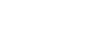
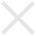
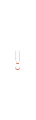
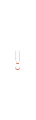
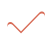
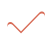
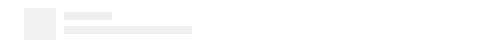
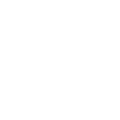
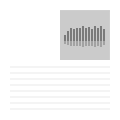
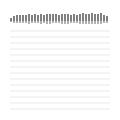

In [22]:
driver.get('https://soundcloud.com/f0uynmuak9ng/sets/metal')
source = driver.page_source
source

In [ ]:
driver.quit()

In [ ]:
def create_track_link_list(playlist_link, start):
    track_link = set()
    

In [17]:
a = '{"artwork_url":"https://i1.sndcdn.com/artworks-000013259385-1g6mxb-large.jpg", "sth":null}'
b = json.loads(a)
print(b["artwork_url"])

https://i1.sndcdn.com/artworks-000013259385-1g6mxb-large.jpg


In [2]:
data = {
  "calories": [420, 380, 390],
  "duration": [50, 40, 45]
}

type(data)

dict